In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from cvxpy.atoms.affine.hstack import hstack
from cvxpy.atoms.affine.vstack import vstack
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from algorithms import nuclear_norm_convex_optimization
from experiments import matrix_factorization_multiple_ranks, create_small_incomplete_matrix, load_movie_data

# Small Convex Optimization Example

In [2]:
M, M_true = create_small_incomplete_matrix()
problem, x, w1, w2 = nuclear_norm_convex_optimization(M)

dec = 5
print(f'\nM_hat round to {dec} decimals:')
print(np.around(x.value, dec))

dec = 4
print(f'\nErrors rounded to {dec} decimals')
print(np.around(M_true - x.value, 4))

fraction complete:  0.72
?	0.0	0.0	0.0	0.0	
0.0	?	2.0	3.0	4.0	
0.0	?	?	6.0	8.0	
?	?	6.0	?	12.0	
0.0	4.0	8.0	12.0	16.0	

M_hat round to 5 decimals:
[[ 0.       0.       0.       0.       0.     ]
 [-0.       1.00001  2.       3.       4.     ]
 [-0.       2.00003  4.00001  6.       8.     ]
 [-0.       3.00003  6.       8.99999 12.     ]
 [-0.       4.       8.      12.      16.     ]]

Errors rounded to 4 decimals
[[ 0.  0.  0.  0.  0.]
 [ 0. -0. -0.  0. -0.]
 [ 0. -0. -0. -0. -0.]
 [ 0. -0. -0.  0.  0.]
 [ 0. -0. -0.  0.  0.]]


# MovieLens 100k Ratings Example

## Load data

In [3]:
df = load_movie_data()
display(df)

,user_id,movie_id,rating,timestamp
0,195.0,241.0,3.0,881250949.0
1,185.0,301.0,3.0,891717742.0
2,21.0,376.0,1.0,878887116.0
3,243.0,50.0,2.0,880606923.0
4,165.0,345.0,1.0,886397596.0
...,...,...,...,...
99995,879.0,475.0,3.0,880175444.0
99996,715.0,203.0,5.0,879795543.0
99997,275.0,1089.0,1.0,874795795.0
99998,12.0,224.0,2.0,882399156.0


## Create training and test matrices

In [4]:
# 80/20 train/test split
train, test = train_test_split(df, test_size=0.2)

In [5]:
n1 = int(df['user_id'].max()) + 1
n2 = int(df['movie_id'].max()) + 1

M = np.empty((n1,n2))
M_test = np.empty((n1,n2))
M[:] = np.nan
M_test[:] = np.nan

for _, r in train.iterrows():
    M[(int(r['user_id']), int(r['movie_id']))] = r['rating']
for _, r in test.iterrows():
    M_test[(int(r['user_id']), int(r['movie_id']))] = r['rating']

## Run the algorithm for a range of ranks

In [7]:
min_rank, max_rank = 1, 15
ranks = range(min_rank, max_rank+1)
alpha, max_iters = 0.0001, 500
results_dict_movies = matrix_factorization_multiple_ranks(M, ranks, 
                                                          m_test=M_test, 
                                                          alpha=alpha, 
                                                          max_iters=max_iters)

## Results

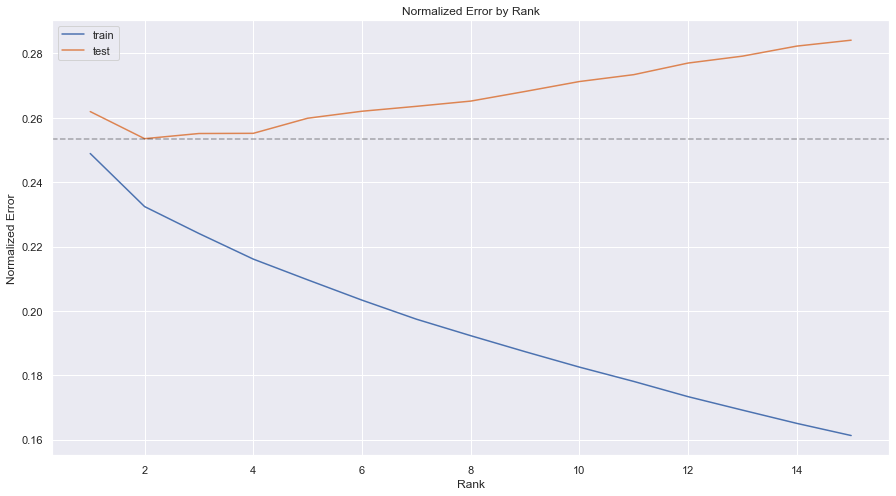

In [8]:
train_errors = [results_dict_movies[i]['train_error'] for i in ranks]
test_errors = [results_dict_movies[i]['test_error'] for i in ranks]
plt.figure(figsize=(15,8))
plt.plot(ranks, train_errors, label='train')
plt.plot(ranks, test_errors, label='test')
plt.axhline(min(test_errors), ls='--', alpha=0.3, c='black')
plt.xlabel('Rank')
plt.ylabel('Normalized Error')
plt.title("Normalized Error by Rank")
plt.legend()
plt.show()

# Image Reconstruction Example

In [9]:
import PIL
from PIL import Image

In [14]:
image = Image.open('data/cat.jpg').convert('L')
image_arr = np.asarray(image)
image_arr_corrupted = image_arr.astype(float)

## Load image image into matrix and corrupt the matrix

In [16]:
image = Image.open('data/cat.jpg').convert('L')
image_arr = np.asarray(image)
image_arr_corrupted = image_arr.astype(float)

w,h = image_arr_corrupted.shape
for _ in range(200000):
    image_arr_corrupted[np.random.randint(0, w - 1), np.random.randint(0, h - 1)] = np.nan

## Run the algorithm for several ranks

In [783]:
M = image_arr_corrupted
M_test = image_arr.astype(float)
M_test[np.where(~np.isnan(M))] = np.nan
alpha, max_iters = 0.00001, 300
ranks = np.linspace(10, 100, 5).astype(int)
results_dict_cat = matrix_factorization_multiple_ranks(M, ranks,
                                                       M_test=M_test,
                                                       alpha=alpha,
                                                       max_iters=max_iters)

## Results

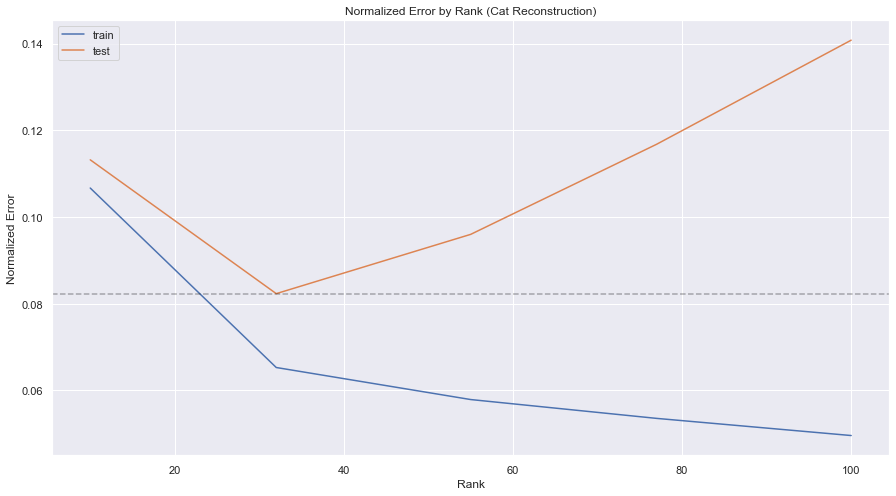

In [786]:
train_errors = [results_dict_cat[i]['train_error'] for i in ranks]
test_errors = [results_dict_cat[i]['test_error'] for i in ranks]
plt.figure(figsize=(15,8))
plt.plot(ranks, train_errors, label='train')
plt.plot(ranks, test_errors, label='test')
plt.axhline(min(test_errors), ls='--', alpha=0.3, c='black')
plt.xlabel('Rank')
plt.ylabel('Normalized Error')
plt.title("Normalized Error by Rank (Cat Reconstruction)")
plt.legend()
plt.show()

## Display reconstructed images

10


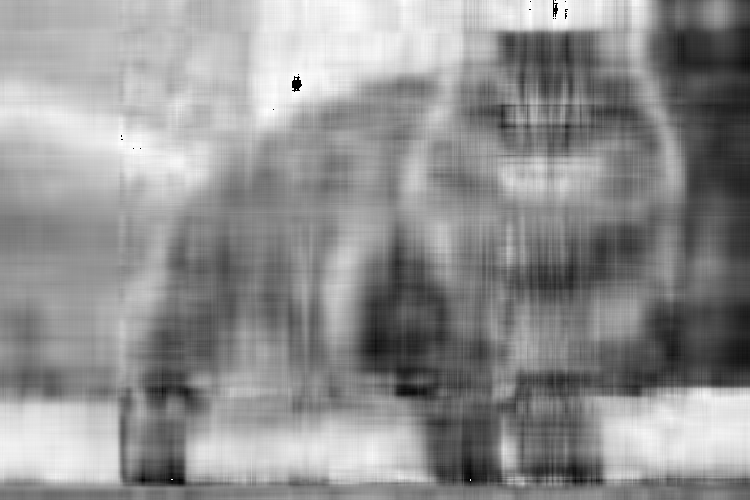

32


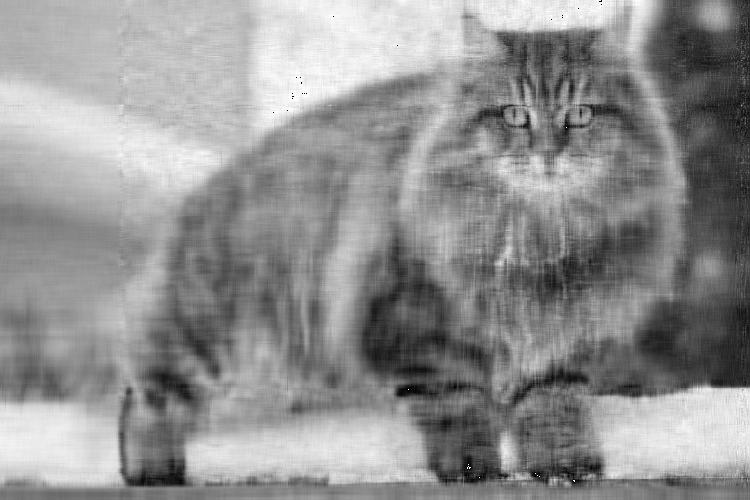

55


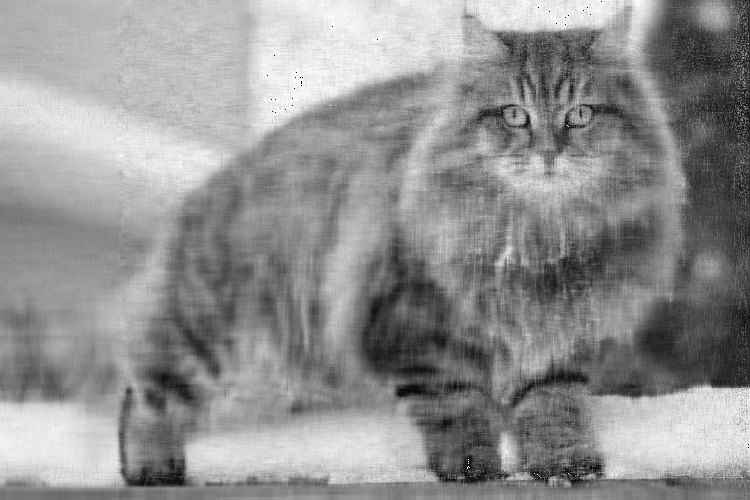

77


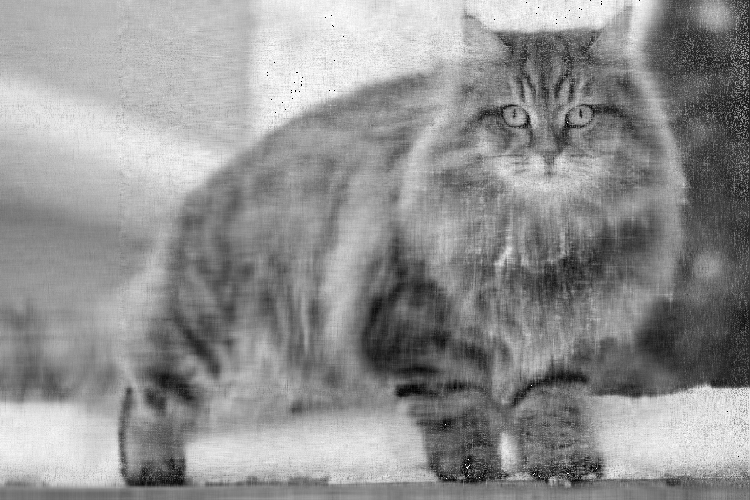

100


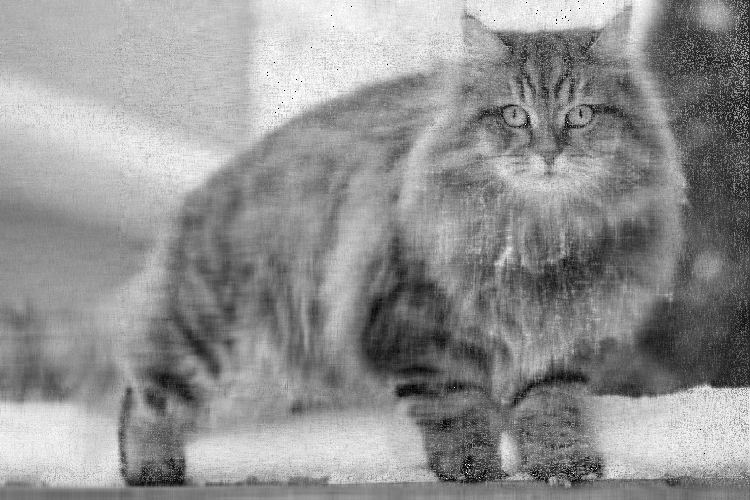

corrupted


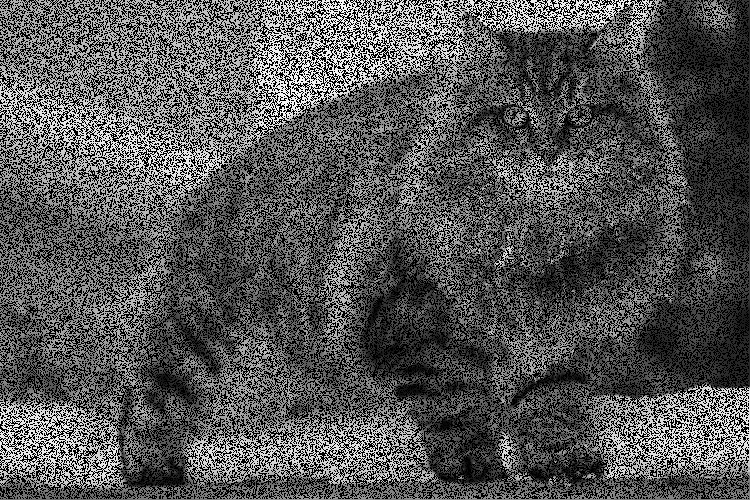

original


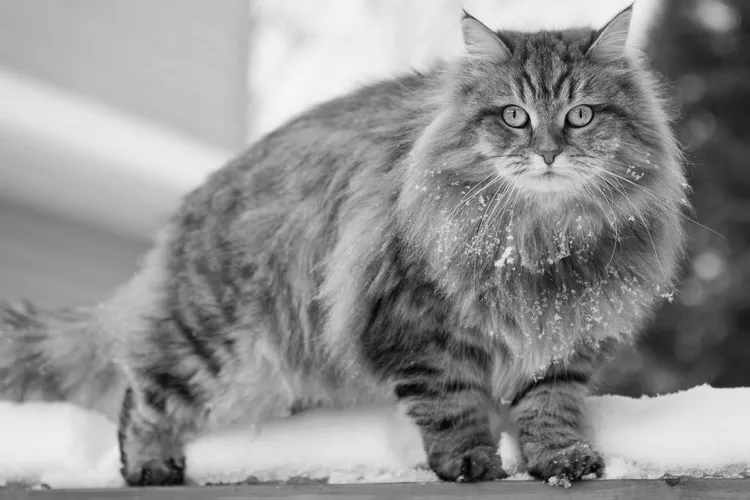

In [787]:
for r, d in results_dict_cat.items():
    print(r)
    display(PIL.Image.fromarray(d['M_hat'].astype(np.uint8)))

print('corrupted')
display(PIL.Image.fromarray(image_arr_corrupted.astype(np.uint8)))
print('original')
display(PIL.Image.fromarray(image_arr))